# Exercise 7: ARIMAX versus ARDL models

## Compute continuous quarterly returns of BNP 5Y CDS:

In [1]:
#libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install arch
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
import statsmodels.stats.diagnostic as dg
from statsmodels import tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('BNP_CDS.xlsx', index_col=0)
df = df.sort_values(by='Date', ascending=True)

df_logret = np.log(df['Last Price'].iloc[1:]).diff().dropna()
df_quarterly = df_logret.resample('Q').sum() #== because log returns are additive
df_quarterly.tail()

Date
2021-09-30    0.046879
2021-12-31   -0.045444
2022-03-31    0.377333
2022-06-30    0.420382
2022-09-30    0.160980
Freq: Q-DEC, Name: Last Price, dtype: float64

In [3]:
#split in train (from 01/01/2010 until 31/03/2022) and test (01/04/2022 until 30/09/2022):
df_train = df_quarterly.loc['2010-03-31' : '2021-03-31']
df_test = df_quarterly.loc['2021-06-30' : '2022-09-30']

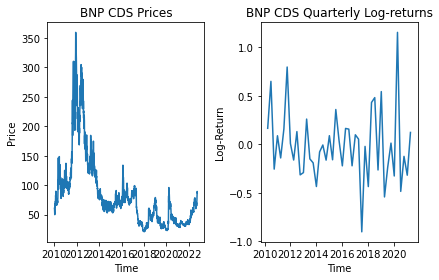

In [4]:
#================== Visual representation ===================

# Check the CDS price's fluctuation
plt.subplot(1, 2, 1)
plt.plot(df['Last Price'])
plt.title("BNP CDS Prices")
plt.xlabel('Time')
plt.ylabel('Price')
# Check the evolution of log-returns
plt.subplot(1, 2, 2)
plt.plot(df_train)
plt.title("BNP CDS Quarterly Log-returns")
plt.xlabel('Time')
plt.ylabel('Log-Return')
plt.tight_layout()

## Visual inspection of ACF/PACF and Unit Root detection

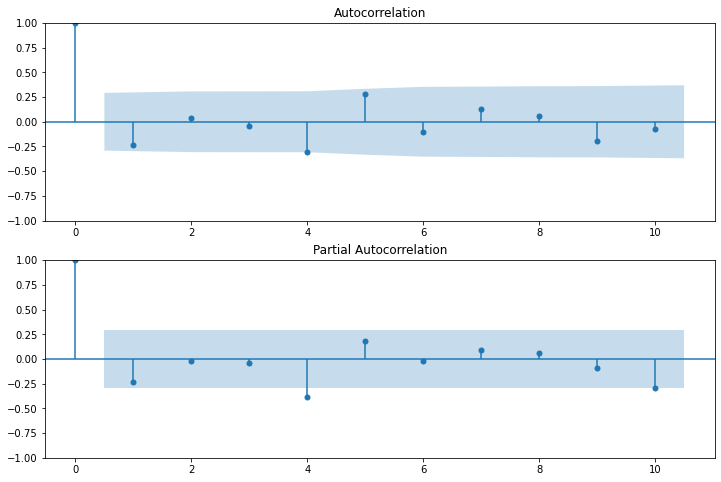

In [5]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train, lags=10, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train, lags=10, ax=ax2) 

In [6]:
test = adfuller(df_train)
df_adf = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['Output'])
df_adf['Output']['Test Statistic Value'] = test[0]
df_adf['Output']['p-value'] = test[1]
df_adf['Output']['Lags Used'] = test[2]
df_adf['Output']['Number of Observations Used'] = test[3]
df_adf['Output']['Critical Value(1%)'] = test[4]['1%']
df_adf['Output']['Critical Value(5%)'] = test[4]['5%']
df_adf['Output']['Critical Value(10%)'] = test[4]['10%']
df_adf

Output
Test Statistic Value        -4.904038
p-value                      0.000034
Lags Used                           3
Number of Observations Used        41
Critical Value(1%)          -3.600983
Critical Value(5%)          -2.935135
Critical Value(10%)         -2.605963

The null hypothesis is rejected: the process is **stationary** (pvalue above thresholds & t-stat > critical value). There is no need for differentiating.

## Fitting an ARIMA model:

In [7]:
from itertools import product
ar_order = [0, 1, 2, 3, 4, 5]
ma_order = [0, 1, 2, 3, 4, 5]
arma_res = [list(orders) for orders in product(ar_order, ma_order)]
#     pprint.pprint(arma_res)

for n in arma_res:
    print('fitting: ar:{} - ma:{}'.format(*n)) 
    try:
        arma_model  = tsa.arima.model.ARIMA(df_train, order= (n[0], 0, n[1])).fit()
        n.extend([arma_model.aic / 1e3, arma_model.bic / 1e3])
    except Exception as exception:
        print(exception.__str__())
        n.extend([np.NaN, np.NaN])
    
res = pd.DataFrame(arma_res, columns = ['ar_order', 'ma_order', 'aic', 'bic'])
print('criterion\n', res)

fitting: ar:0 - ma:0
fitting: ar:0 - ma:1
fitting: ar:0 - ma:2
fitting: ar:0 - ma:3
fitting: ar:0 - ma:4
fitting: ar:0 - ma:5
fitting: ar:1 - ma:0
fitting: ar:1 - ma:1
fitting: ar:1 - ma:2
fitting: ar:1 - ma:3
fitting: ar:1 - ma:4
fitting: ar:1 - ma:5
fitting: ar:2 - ma:0
fitting: ar:2 - ma:1
fitting: ar:2 - ma:2
fitting: ar:2 - ma:3
fitting: ar:2 - ma:4
fitting: ar:2 - ma:5
fitting: ar:3 - ma:0
fitting: ar:3 - ma:1
fitting: ar:3 - ma:2
fitting: ar:3 - ma:3
fitting: ar:3 - ma:4
fitting: ar:3 - ma:5
fitting: ar:4 - ma:0
fitting: ar:4 - ma:1
fitting: ar:4 - ma:2
fitting: ar:4 - ma:3
fitting: ar:4 - ma:4
fitting: ar:4 - ma:5
fitting: ar:5 - ma:0
fitting: ar:5 - ma:1
fitting: ar:5 - ma:2
fitting: ar:5 - ma:3
fitting: ar:5 - ma:4
fitting: ar:5 - ma:5
criterion
     ar_order  ma_order       aic       bic
0          0         0  0.041341  0.044954
1          0         1  0.040809  0.046229
2          0         2  0.042723  0.049949
3          0         3  0.042663  0.051697
4          0      

In [8]:
#========= confirming order chosen ============
sm.tsa.arma_order_select_ic(df_train,max_ar=5,max_ma=5,ic='aic')['aic_min_order']

(4, 1)

**Order chosen is an ARIMA (4,0,1)** based on the AIC criteria

## Test for ARCH effect:

First we take the residuals from the ARMA(1,1) estimation, square them and regress them on q lagged values.

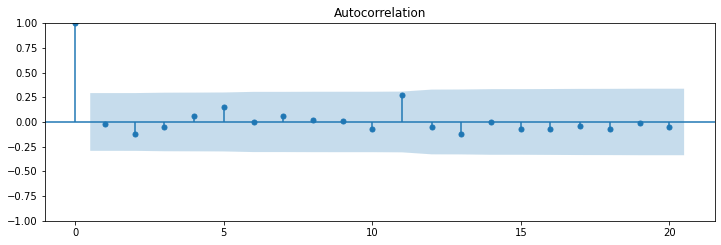

In [9]:
#===== ARCH test with the Ljung-Box on the squared residuals =======================

df_train_res = df_train - np.mean(df_train)
sq_df_train_res = df_train_res**2

#======== ACF and of squared residuals: ========
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sq_df_train_res, lags=20, ax=ax1)

According to the ACF of the squared residuals, we see no significant positive autocorrelation betwteen the residuals and thus reject the null hypothesis.

## Test for GARCH process features:

First we construct the standardized residuals and run a normality test on them (Jarque-Bera test):

In [10]:
df_train_res = (df_train - np.mean(df_train)) / np.std(df_train)
nb_obs = len(df_train_res)

jb = sm.stats.stattools.jarque_bera(df_train_res, axis=0)
print(jb)

(7.302026380062027, 0.025964808162326637, 0.7039375837380424, 4.382859928615549)


This Jarque-Bera test is a goodness-of-fit test that returns the JB t-stat, p-value, skewness and the kurtosis. **We don't reject the null hypothesis of a normal distribution** (p-value being above the threshold) and confirm the absence of a GARCH process.

## Forecast an ARIMA(4,0,1) for the next 6 periods:

In [11]:
arma_model  = tsa.arima.model.ARIMA(df_train, order=(4,0,1)).fit()
arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Last Price   No. Observations:                   45
Model:                 ARIMA(4, 0, 1)   Log Likelihood                 -12.740
Date:                Fri, 23 Dec 2022   AIC                             39.480
Time:                        19:23:58   BIC                             52.127
Sample:                    03-31-2010   HQIC                            44.195
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0103      0.034     -0.306      0.759      -0.076       0.056
ar.L1         -0.7981      0.322     -2.481      0.013      -1.429      -0.168
ar.L2         -0.2061      0.251     -0.823      0.411      -0.697       0.285
ar.L3         -0.1818      0.219     -0.828      0.407      -0.612       0.248
ar.L4         -0.4315      0.150     -2.878      0.004      -0.725      -0.138
ma.L1          0.6998      0.340      2.057      0.040       0.033       1.367
sigma2         0.0998      0.022      4.533      0.000       0.057       0.143
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.23
Prob(Q):                              0.97   Prob(JB):                         0.89
Heteroskedasticity (H):               1.05   Skew:                             0.08
Prob(H) (two-sided):                  0.92   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ar.L1, ar.L4 and ma.L1 coefficient are significant (with p-value below 0.05)

In [12]:
forecast_arma = arma_model.forecast(6)
forecast_arma = pd.DataFrame({'Projected return' : forecast_arma})
forecast_arma

Projected return
2021-06-30          0.527999
2021-09-30         -0.361628
2021-12-31          0.268215
2022-03-31         -0.315108
2022-06-30          0.007123
2022-09-30          0.139525

## Graph comparaison of forecasts versus real values:

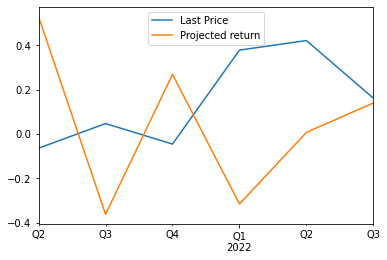

In [13]:
output = pd.concat([df_test, forecast_arma['Projected return']], axis=1)
output.plot()
plt.show()

# <font color='blue'> Time to build an alternative model:

Here are the exogenous explanatory variables download from bloomberg that will be used to explain the quarterly CDS returns:
- Euribor 3 months Index
- CAC40 Index
- EURUSD Curncy
- ECB Main Refinancing Operations Rate
- BNP FP Equity

In [14]:
df_2 = pd.read_excel('Variables.xlsx', index_col=0).dropna()
df_2 = df_2.sort_values(by='Date', ascending=True)
df_2

BNP CDS  EUR003M Index  CAC Index  EURUSD Curncy   ECB  \
Date                                                                 
2010-01-04   59.543          0.700    4013.97         1.4413  0.00   
2010-01-05   57.312          0.699    4012.91         1.4365  0.00   
2010-01-06   56.081          0.694    4017.67         1.4408  0.00   
2010-01-07   52.640          0.692    4024.80         1.4308  0.00   
2010-01-08   52.432          0.691    4045.14         1.4409  0.00   
...             ...            ...        ...            ...   ...   
2022-09-26   84.830          1.168    5769.39         0.9609  1.25   
2022-09-27   84.193          1.228    5753.82         0.9594  1.25   
2022-09-28   85.158          1.193    5765.01         0.9735  1.25   
2022-09-29   89.461          1.160    5676.87         0.9815  1.25   
2022-09-30   87.349          1.173    5762.34         0.9802  1.25   

            BNP FP Equity  
Date                       
2010-01-04         57.240  
2010-01-05         57.130  
2010-01-06         57.220  
2010-01-07         58.220  
2010-01-08         59.600  
...                   ...  
2022-09-26         46.210  
2022-09-27         45.110  
2022-09-28         43.350  
2022-09-29         42.535  
2022-09-30         43.605  

[3267 rows x 6 columns]

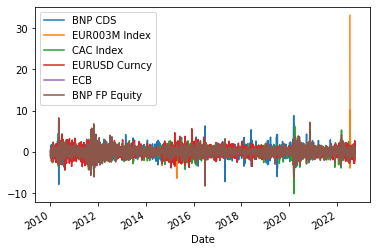

In [15]:
#===== Computing returns and standardizing them to get rid of scale effect ?? =================

df_returns = np.log(df_2).diff()
#standardized :
df_returns_std = (df_returns - np.mean(df_returns)) / np.std(df_returns)
df_returns_std.plot()
plt.show()

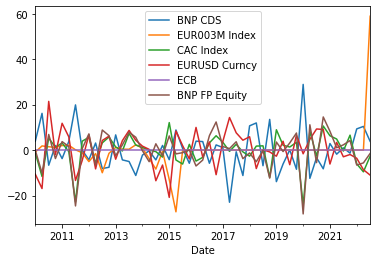

In [16]:
#========= Keeping only quartelry returns ===============

#compunting quarterly returns
df_returns_quarterly = df_returns_std.resample('Q').sum()
df_returns_quarterly.plot()
plt.show()

In [17]:
#split in train (from 01/01/2010 until 31/03/2022) and test (01/04/2022 until 30/09/2022):
df2_train = df_returns_quarterly.loc['2010-03-31' : '2021-03-31']
df2_test = df_returns_quarterly.loc['2021-06-30' : '2022-09-30']

## 1. The ARIMAX model:

In [18]:
#===== Checking for unit root in the series ===========

print(adfuller(df2_train['EUR003M Index']))
print(adfuller(df2_train['CAC Index']))
print(adfuller(df2_train['EURUSD Curncy']))
print(adfuller(df2_train['ECB']))
print(adfuller(df2_train['BNP FP Equity']))

(-4.519060159108634, 0.00018162061632537638, 0, 44, {'1%': -3.5885733964124715, '5%': -2.929885661157025, '10%': -2.6031845661157025}, 208.89403363592075)
(-8.137826710320617, 1.0475666587142337e-12, 0, 44, {'1%': -3.5885733964124715, '5%': -2.929885661157025, '10%': -2.6031845661157025}, 225.91749505056652)
(-7.060095278037164, 5.250822016833369e-10, 0, 44, {'1%': -3.5885733964124715, '5%': -2.929885661157025, '10%': -2.6031845661157025}, 236.5367617824702)
(nan, nan, 0, 44, {'1%': -3.5885733964124715, '5%': -2.929885661157025, '10%': -2.6031845661157025}, -inf)
(-8.115435800987758, 1.1945040822785267e-12, 0, 44, {'1%': -3.5885733964124715, '5%': -2.929885661157025, '10%': -2.6031845661157025}, 237.1693934011399)


For all time series **except for the Euribor 3 months**, we don't reject the null of unit root. The processes are thus **not stationary** and we should differenciate series as a first step.

In [19]:
#=== Creating the data frame with the differenced time-series =======
df_diff=pd.DataFrame(index=df2_train.index)
df_diff['E3M'] = df2_train['EUR003M Index'] #=== not differenciating for this time series which is stationnary
df_diff['CAC40'] = df2_train['CAC Index'].diff()
df_diff['EURUSD'] = df2_train['EURUSD Curncy'].diff()
df_diff['ECB'] = df2_train['ECB'].diff()
df_diff['BNP Equity'] = df2_train['BNP FP Equity'].diff()
df_diff.head()

E3M      CAC40     EURUSD  ECB  BNP Equity
Date                                                       
2010-03-31 -0.841876        NaN        NaN  NaN         NaN
2010-06-30  1.829701 -10.289592  -6.300864  0.0  -10.076757
2010-09-30  1.469157  16.889828  38.334977  0.0   17.015393
2010-12-31  1.185868  -4.027774 -23.402718  0.0  -10.602672
2011-03-31  1.995848   1.827113  13.777871  0.0    7.459474

In [20]:
#========= fitting an ARIMAX model =================

arimax_model  = tsa.arima.model.ARIMA(endog=df2_train['BNP CDS'].iloc[1:],
                                      exog=df_diff.dropna(), order=(4,1,1)).fit()
arimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                BNP CDS   No. Observations:                   44
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -139.932
Date:                Fri, 23 Dec 2022   AIC                            301.865
Time:                        19:24:03   BIC                            321.238
Sample:                    06-30-2010   HQIC                           309.009
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
E3M           -0.4111      0.355     -1.159      0.246      -1.106       0.284
CAC40          0.0775      0.240      0.323      0.746      -0.392       0.547
EURUSD        -0.0493      0.149     -0.330      0.741      -0.342       0.243
ECB                 0   1.41e+06          0      1.000   -2.77e+06    2.77e+06
BNP Equity    -0.5264      0.224     -2.347      0.019      -0.966      -0.087
ar.L1         -0.2689      0.208     -1.295      0.195      -0.676       0.138
ar.L2         -0.1841      0.175     -1.052      0.293      -0.527       0.159
ar.L3         -0.2101      0.146     -1.438      0.151      -0.496       0.076
ar.L4         -0.6551      0.178     -3.681      0.000      -1.004      -0.306
ma.L1         -0.4796      0.255     -1.881      0.060      -0.979       0.020
sigma2        36.6384      8.967      4.086      0.000      19.064      54.213
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 4.85
Prob(Q):                              0.74   Prob(JB):                         0.09
Heteroskedasticity (H):               1.34   Skew:                            -0.56
Prob(H) (two-sided):                  0.59   Kurtosis:                         4.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.25e+14. Standard errors may be unstable.
"""

## Forecasts of the ARIMAX model:

In [21]:
#exogenous variables for forecasts:
df2_diff=pd.DataFrame(index=df2_test.index)
df2_diff['E3M'] = df2_test['EUR003M Index'] #=== not differenciating for this time series which is stationnary
df2_diff['CAC40'] = df2_test['CAC Index'].diff()
df2_diff['EURUSD'] = df2_test['EURUSD Curncy'].diff()
df2_diff['ECB'] = df2_test['ECB'].diff()
df2_diff['BNP Equity'] = df2_test['BNP FP Equity'].diff()

forecast_arimax = arimax_model.forecast(5, exog=df2_diff.dropna())
forecast_arimax = pd.DataFrame({'Projected return' : forecast_arimax})
forecast_arimax

Projected return
2021-06-30         -0.030856
2021-09-30          8.734603
2021-12-31          3.840481
2022-03-31          0.775803
2022-06-30        -25.988173

## Graph comparaison of forecasts versus real values:

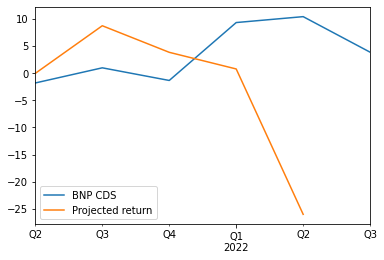

In [22]:
output2 = pd.concat([df2_test['BNP CDS'], forecast_arimax['Projected return']], axis=1)
output2.plot()
plt.show()

## 2. The ARDL model: